## 1. Preparation

In [456]:
import os, sys
sys.path.append(os.path.abspath('../'))

### Import modules

In [457]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime


from storage import MongoDBStorageAdapter
from utils.tools import convert_to_str

## 2. Data fetching and preparation

In this section, our target is to get data and prepare them in the order to be visualized.

### 2.1. Fetch messages from MongoDB

Get raw messages

In [458]:
store = MongoDBStorageAdapter();

all_messages = store.get_all_msgs();

2019-11-17 16:06:51,046 - storage.models - INFO - Try to establish connection to MongoDB instance on mongodb:27017 as 'user' 


Flatten JSON into 2D table

In [459]:
from pandas.io.json import json_normalize

# Transform into flat JSON and make a DateFrame
df = json_normalize(all_messages)

# Make a reserve copy
res_df = df.copy()

Show some of the DF

In [460]:
df.head()

_id                        time message_type  \
0  5dd15f74992810f56430a330  2019-11-17T14:55:48.983940         wifi   
1  5dd15f75992810f56430a331  2019-11-17T14:55:49.686199         wifi   
2  5dd15f76992810f56430a332  2019-11-17T14:55:50.388126         wifi   
3  5dd15f77992810f56430a333  2019-11-17T14:55:51.089675         wifi   
4  5dd15f77992810f56430a334  2019-11-17T14:55:51.792827         wifi   

            longitude            latitude  \
0  -2.970134798675093   56.57107090200052   
1  15.025965299546382   58.87289765874978   
2   9.794540852388977   59.91918254818126   
3  14.188937388001197  49.037819698093855   
4   14.60745134377379   58.45438370297719   

                              device.id device.device_type payload.ssid  \
0  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0              handy        AP #8   
1  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0              handy        AP #8   
2  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0              handy        AP #8   
3  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0              handy        AP #8   
4  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0              handy        AP #8   

       payload.bssid  payload.signal.rssi  
0  02:00:00:c4:f1:99          -158.043192  
1  02:00:00:83:c1:a7          -139.914760  
2  02:00:00:0e:83:cc          -104.883974  
3  02:00:00:c0:cc:57           -70.203496  
4  02:00:00:46:47:04          -127.303677

Show columns

In [461]:
df.columns

Index(['_id', 'time', 'message_type', 'longitude', 'latitude', 'device.id',
       'device.device_type', 'payload.ssid', 'payload.bssid',
       'payload.signal.rssi'],
      dtype='object')

In [462]:
ap_names = df["payload.ssid"].unique()
metric_times = df['time'].unique()

In [463]:
ap_names

array(['AP #8', 'AP #2', 'AP #6', 'AP #4'], dtype=object)

### 2.2. Data Transforming

Transform data to required types

In [464]:
# using dictionary to convert specific columns 
convert_dict = {'longitude': float, 
                'latitude': float,
                'payload.signal.rssi': int,
               } 

df = df.astype(convert_dict) 

df["time"] = pd.to_datetime(df["time"])
df['time'] = df['time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,dt.minute, dt.second))

### 2.3. Data Filtering

Prepare filter for out data

In [465]:
only_handies = df["device.device_type"] == "handy"
has_wifi = df["message_type"] == 'wifi'

Clear out our dataset

In [466]:
only_handies_with_wifi_df = df[only_handies][has_wifi]

Select only necessary columns

In [467]:
wifi_signal_quality_df = only_handies_with_wifi_df[["time","longitude","latitude","device.id",'payload.signal.rssi',"payload.ssid"]]

In [468]:
wifi_signal_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2942 entries, 0 to 2941
Data columns (total 6 columns):
time                   2942 non-null datetime64[ns]
longitude              2942 non-null float64
latitude               2942 non-null float64
device.id              2942 non-null object
payload.signal.rssi    2942 non-null int64
payload.ssid           2942 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 160.9+ KB


## 3. Visualization

In this section, we want to visualize our Wifi Quality Signal data with GPS location.

We target the following diagrams:

1. Mean signal quality estimation for AP  in Time.
2. Changes of GPS location for Client in Time.
3. Estimated signal quality for AP per GPS Location.

### 3.1. Mean signal quality estimation for AP  in Time.

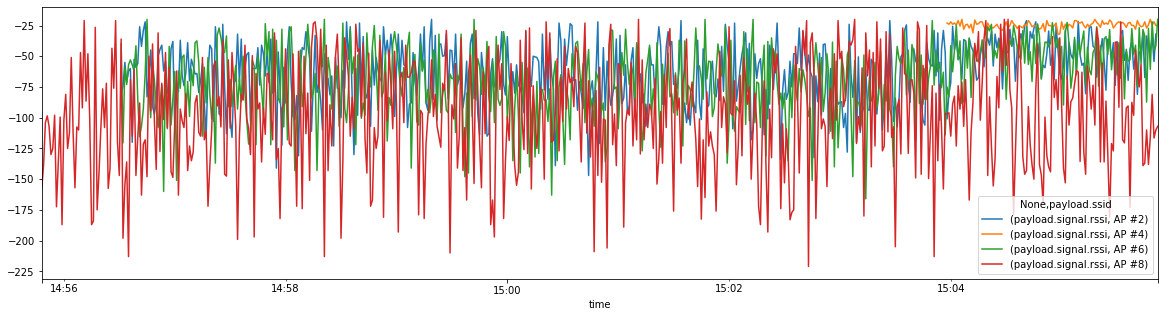

In [482]:
wifi_signal_quality_df[["payload.ssid","time","payload.signal.rssi"]].groupby(["time", "payload.ssid"]).mean().unstack().plot(figsize=(20,5));

In [483]:
grouped_ap_df = wifi_signal_quality_df.groupby(["payload.ssid",])

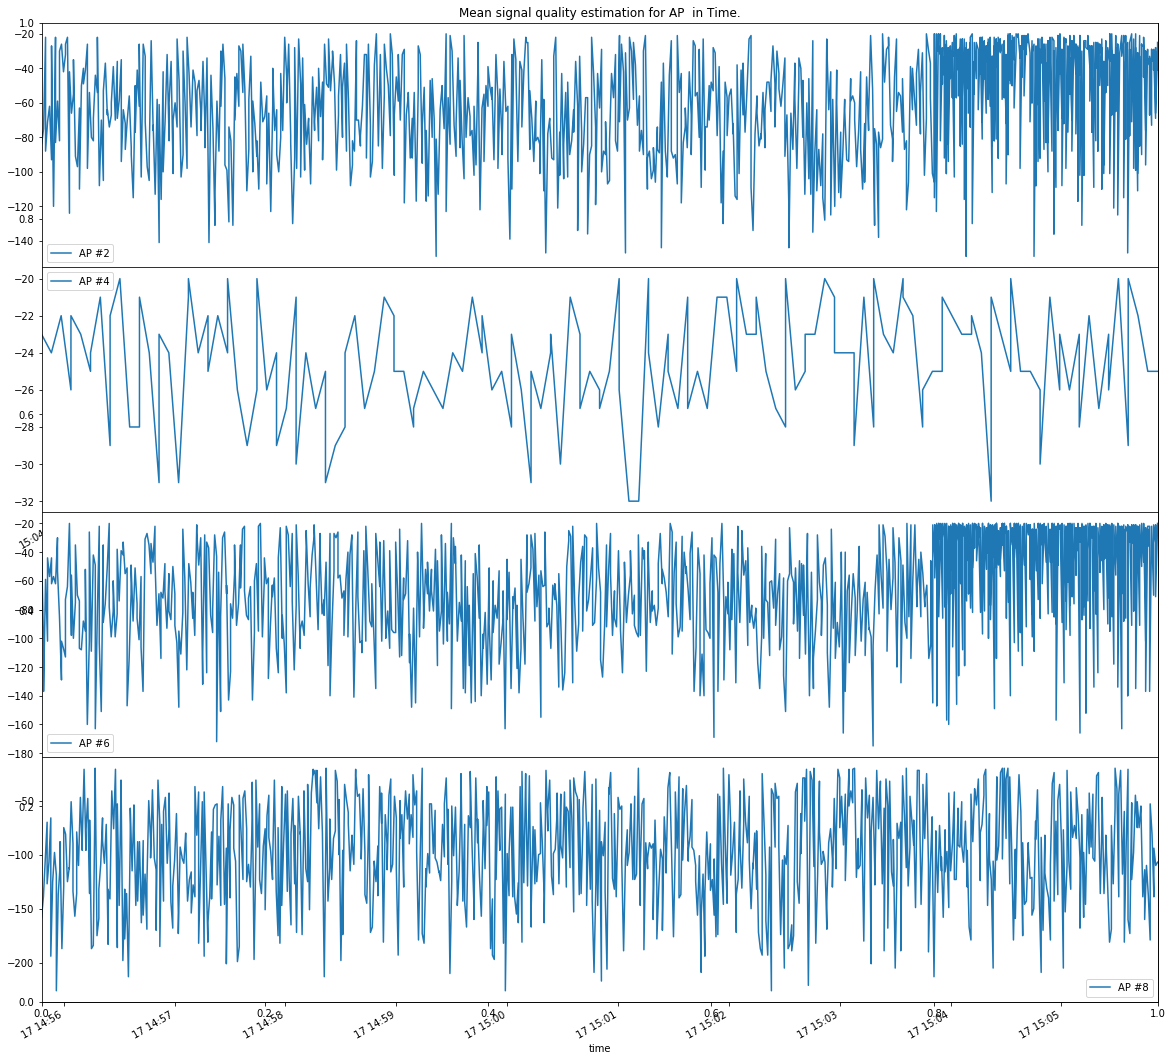

In [485]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0)
plt.title("Mean signal quality estimation for AP  in Time.")

for index,(name, group) in zip(range(1,len(ap_names)+1),grouped_ap_df):
    
    ax = fig.add_subplot(len(ap_names),1,index)

    group.plot(x="time", y="payload.signal.rssi",ax=ax);
    plt.legend([name])

### 3.2. Changes of GPS location for Client in Time.

In [472]:
def normalize_series(x):
    
    normalized = (x-min(x))/(max(x)-min(x))
    
    return normalized


normalize_series(wifi_signal_quality_df["payload.signal.rssi"])

0       0.330097
1       0.422330
2       0.592233
3       0.757282
4       0.480583
          ...   
2937    0.752427
2938    0.975728
2939    1.000000
2940    0.975728
2941    0.577670
Name: payload.signal.rssi, Length: 2942, dtype: float64

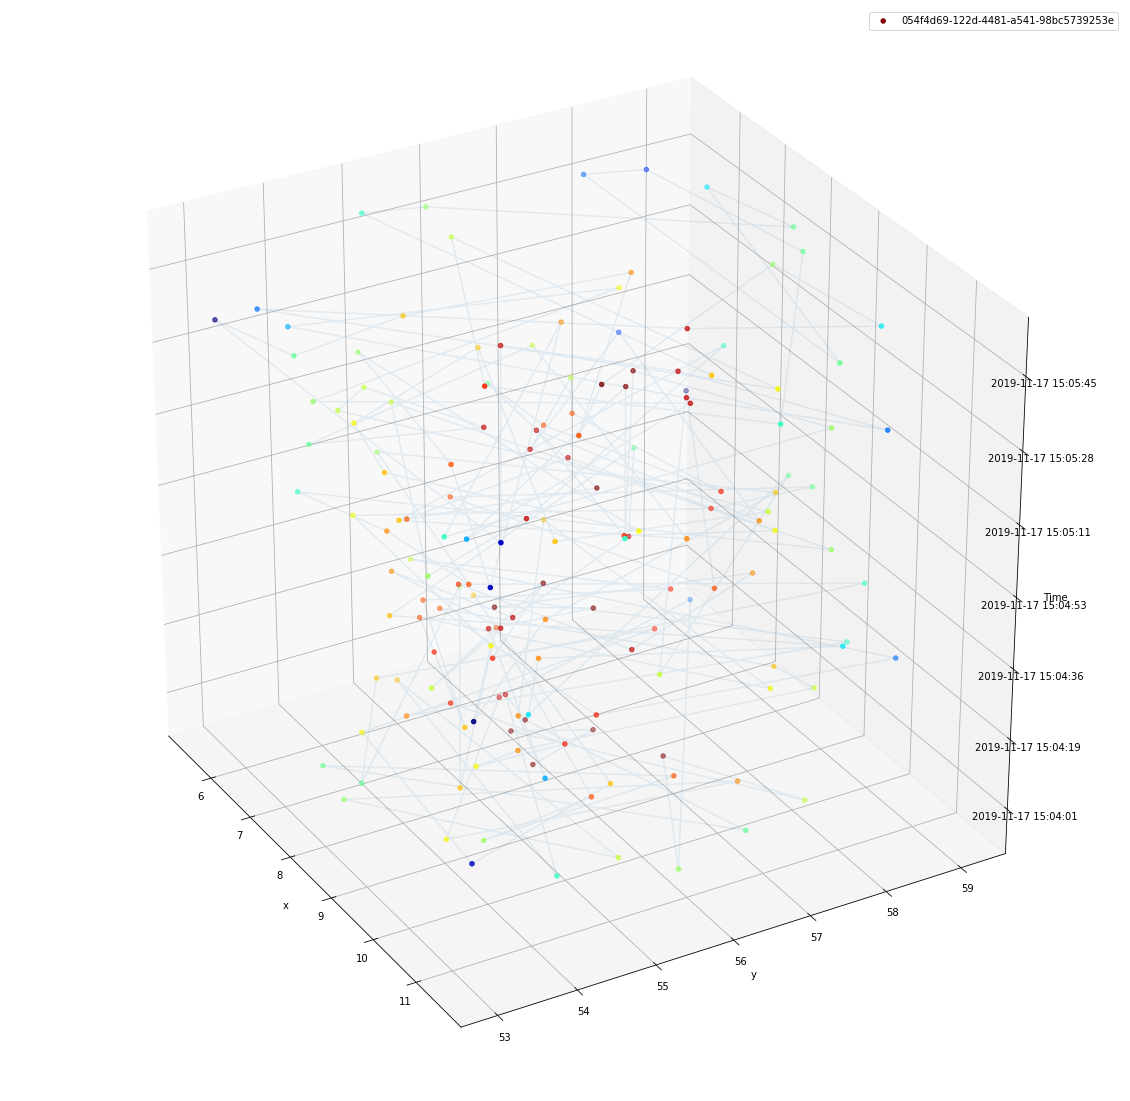

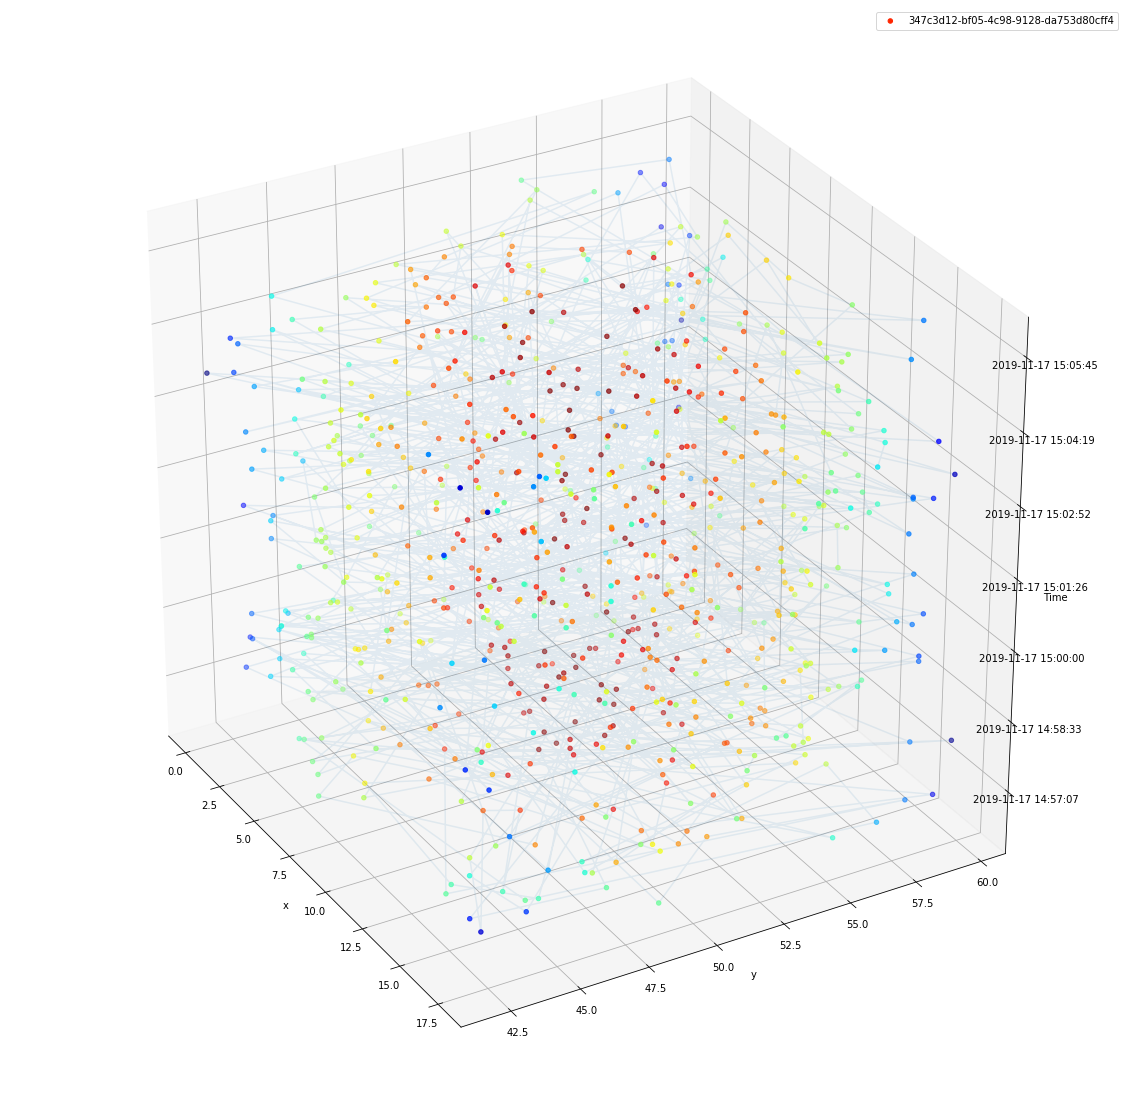

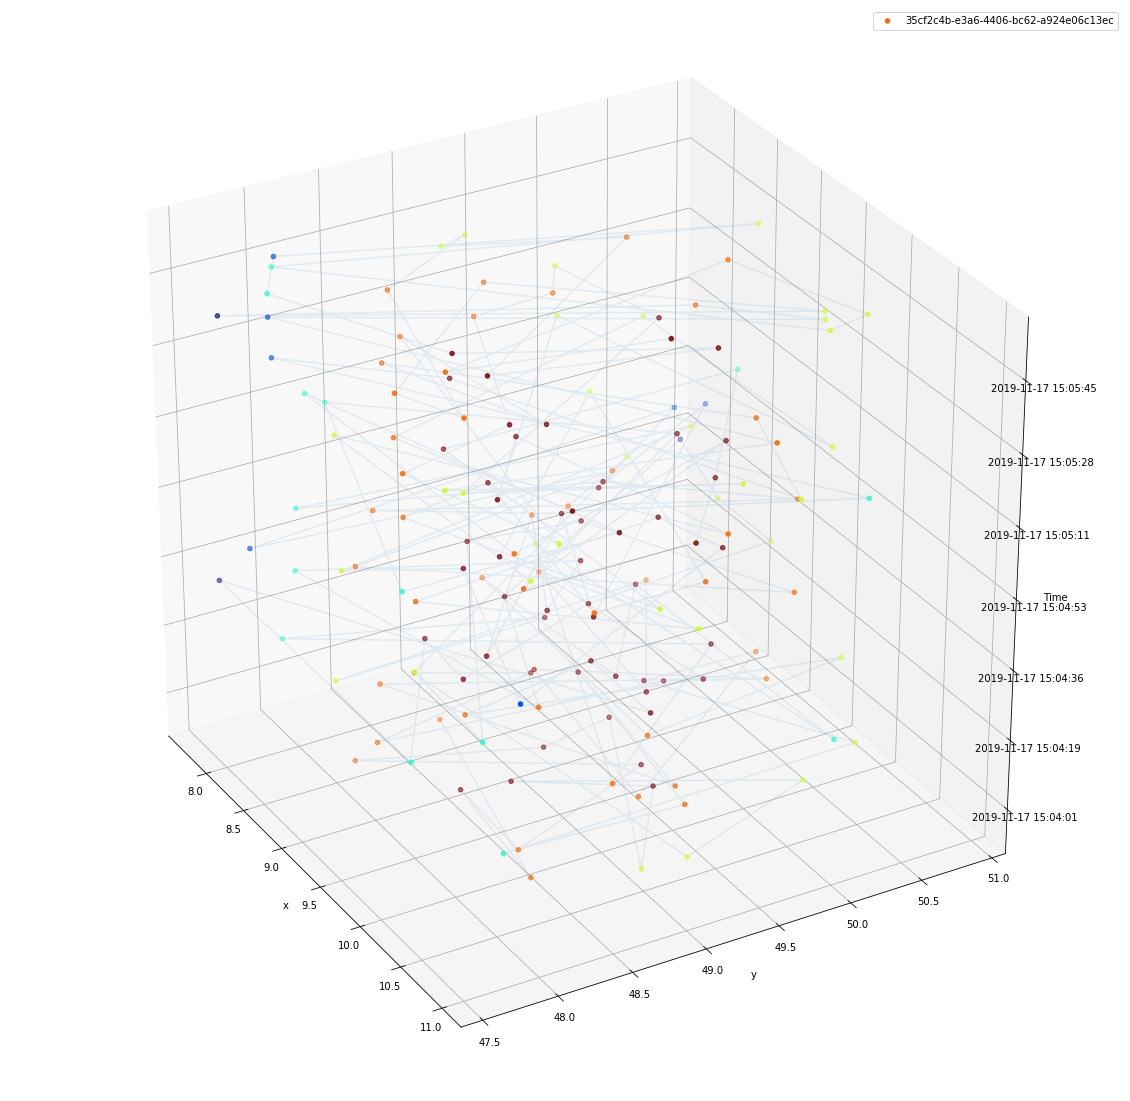

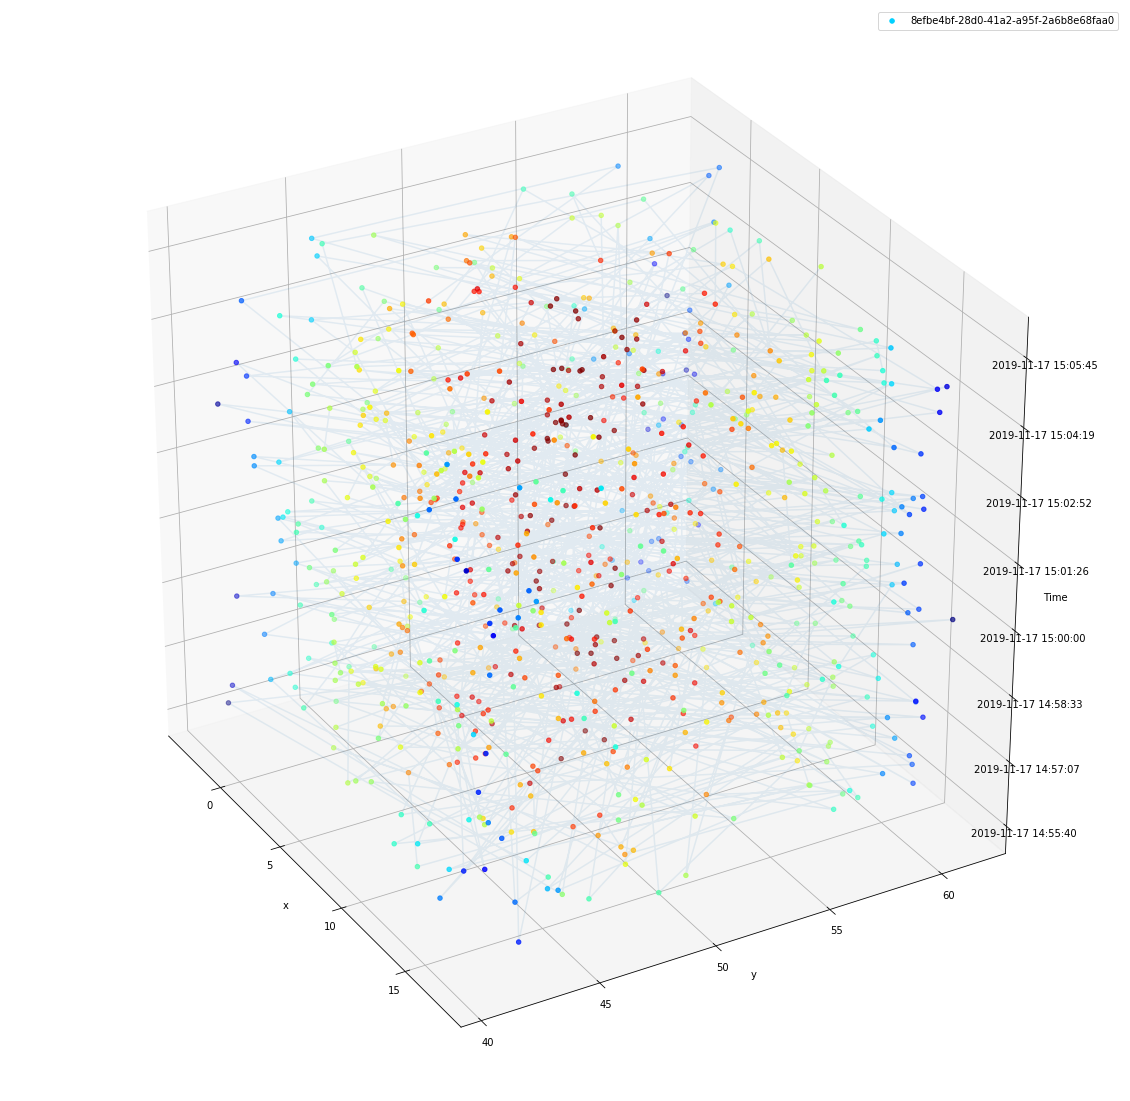

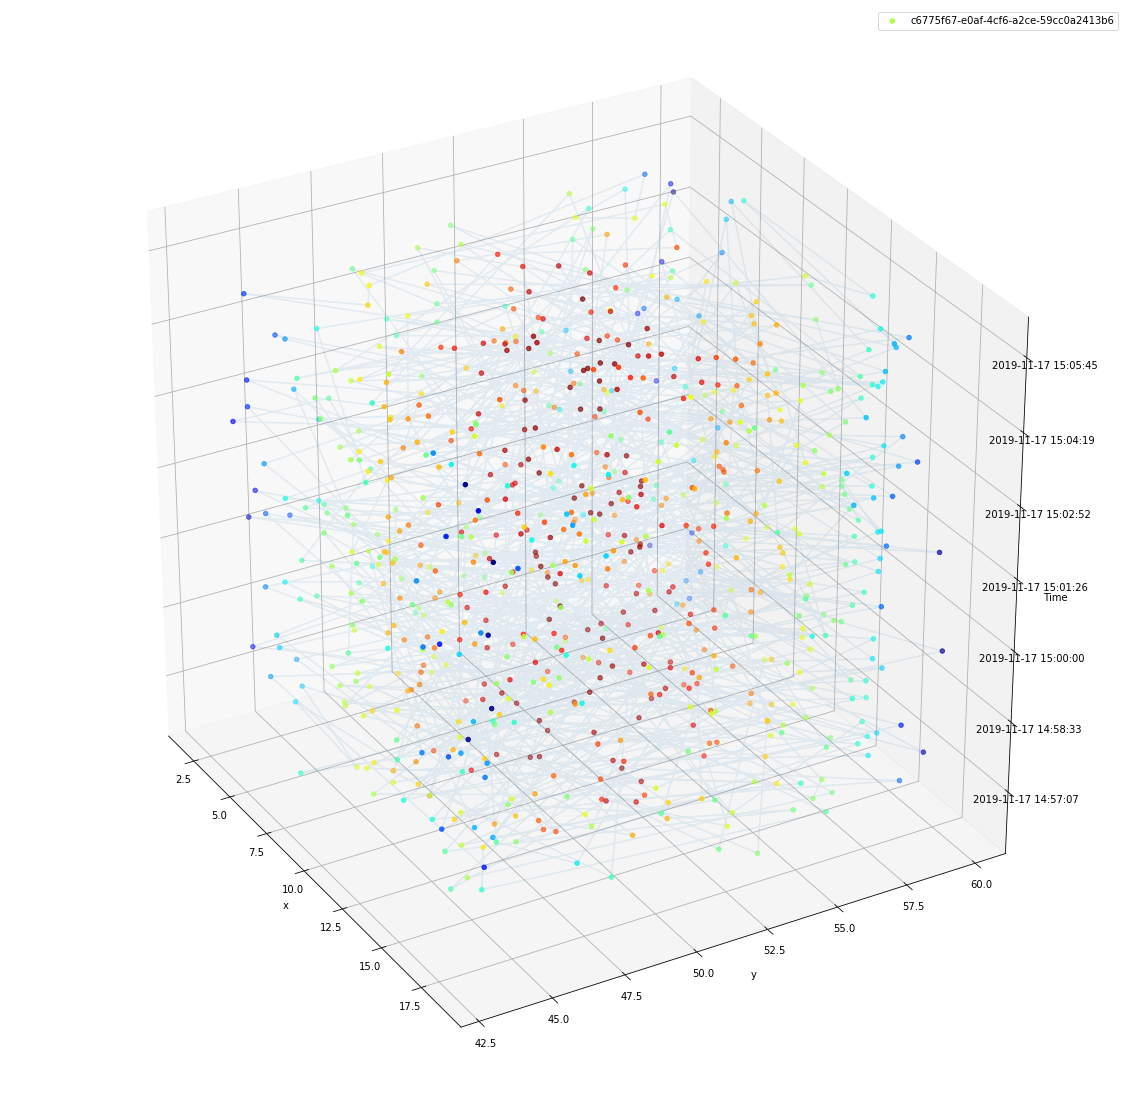

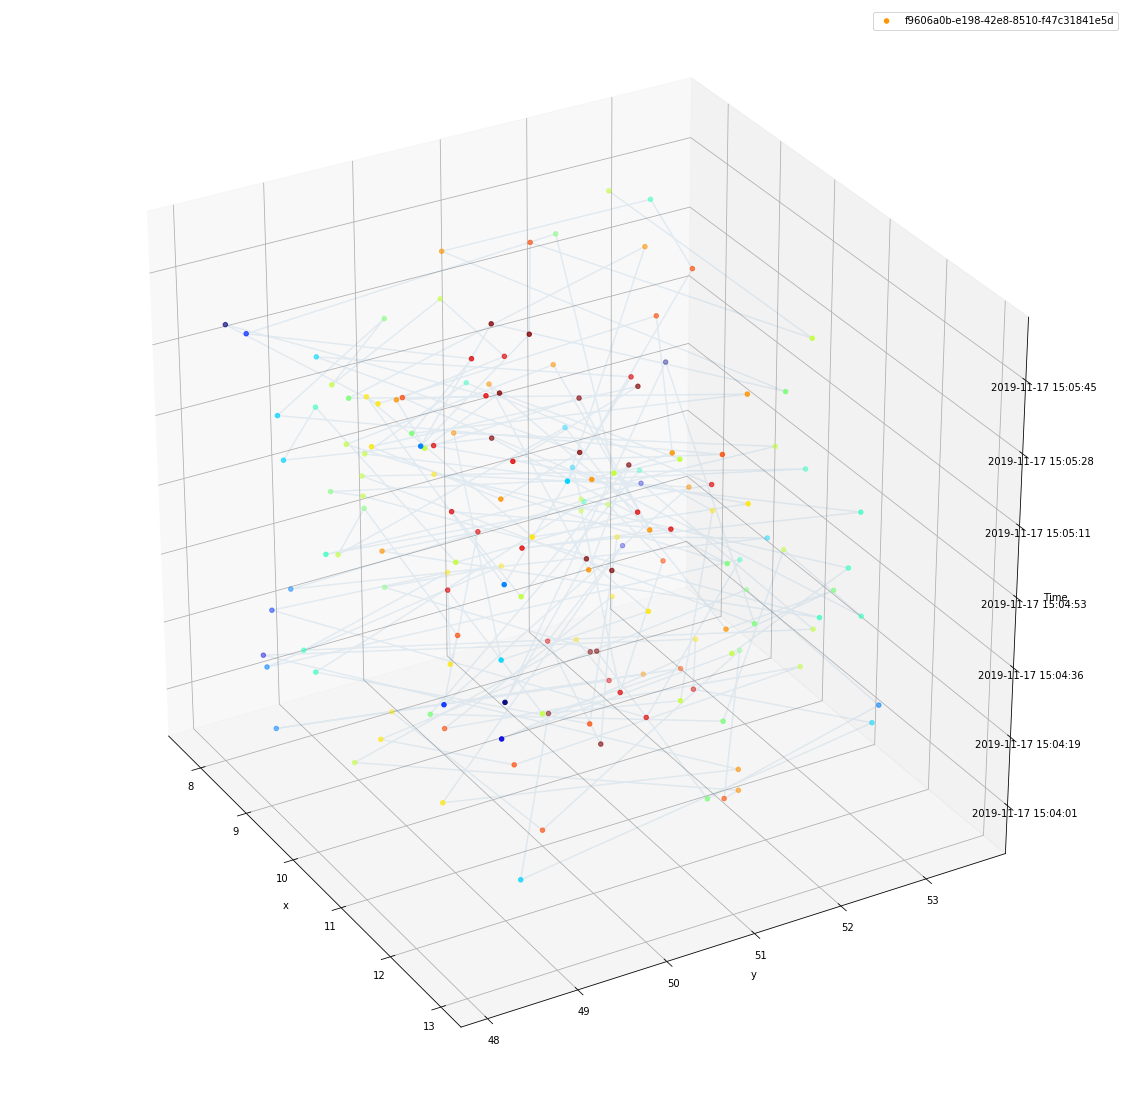

In [491]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import matplotlib.colors as colors


def plot_path(name, group):
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Time')    
    
    ax.plot(group['longitude'].values, group['latitude'].values, mdates.date2num(group['time'].tolist()), alpha=0.1)
    ax.scatter(group['longitude'].values, group['latitude'].values, mdates.date2num(group['time'].tolist()) , label=name, marker="o",c=normalize_series(group["payload.signal.rssi"]), cmap=plt.get_cmap("jet"),)
    ax.zaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax.view_init(30, -30)
    ax.legend()


    
for name, group in wifi_signal_quality_df.groupby("device.id"):
    
    plot_path(name,group)

### 3.3. Estimated signal quality for AP per GPS Location.

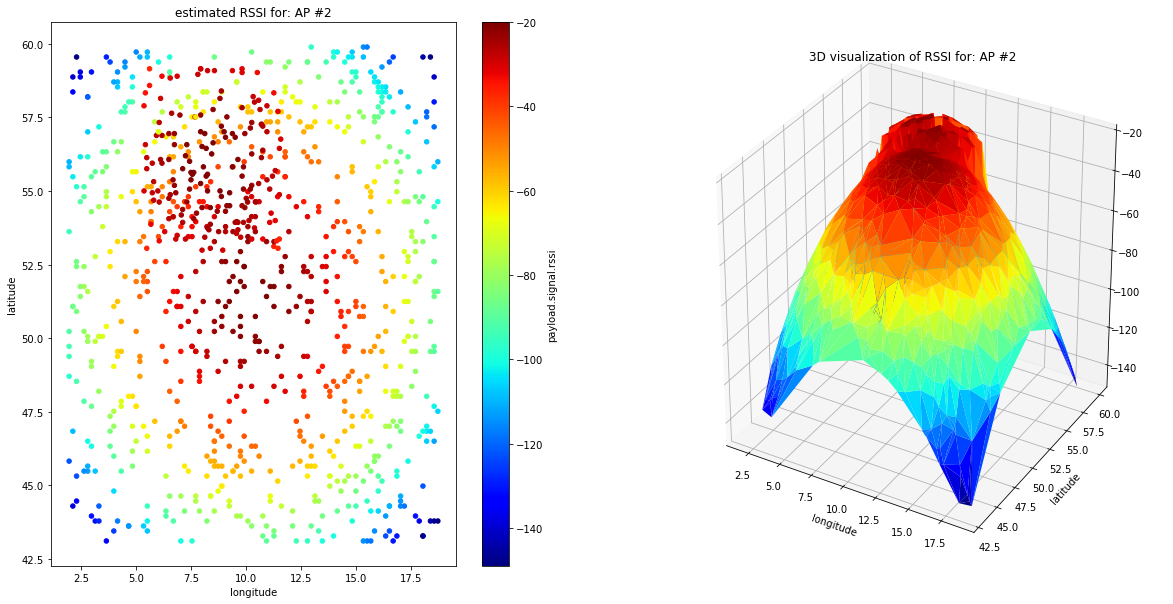

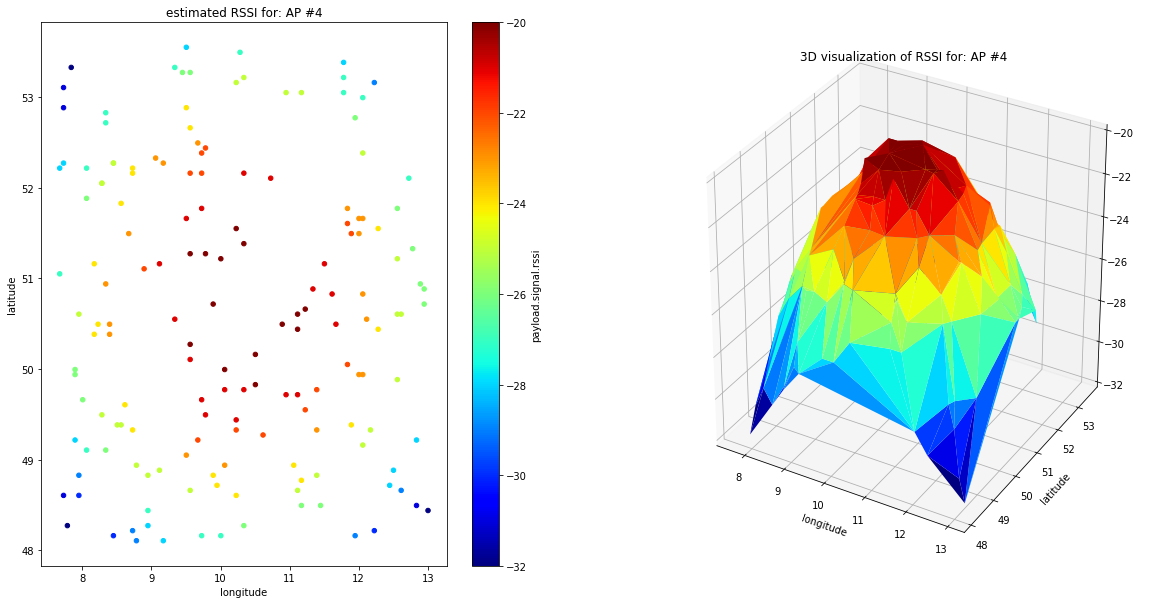

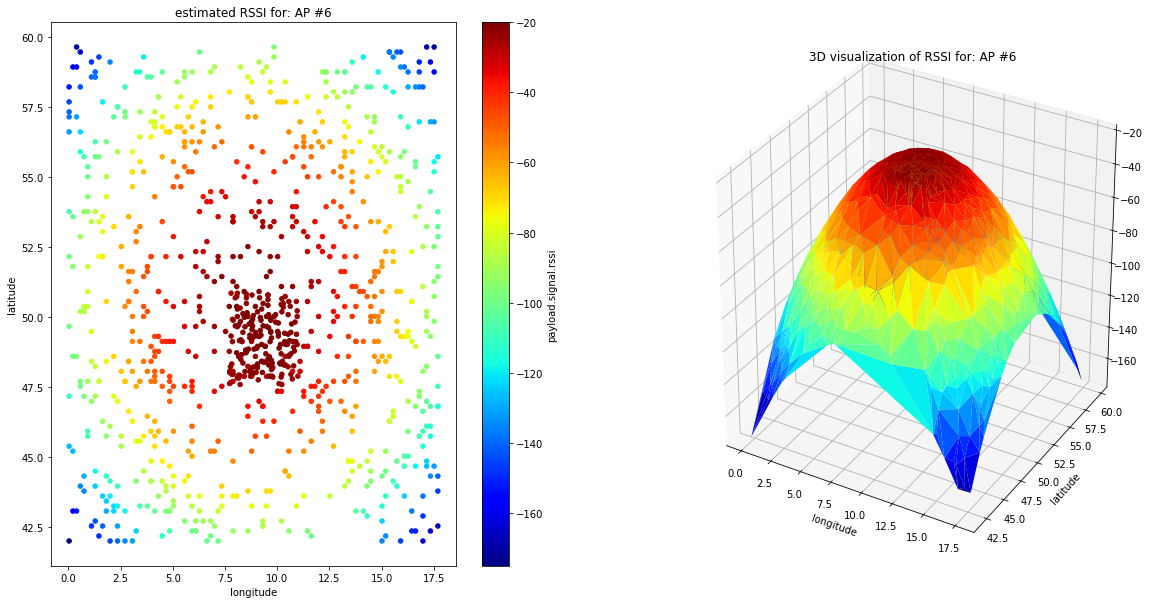

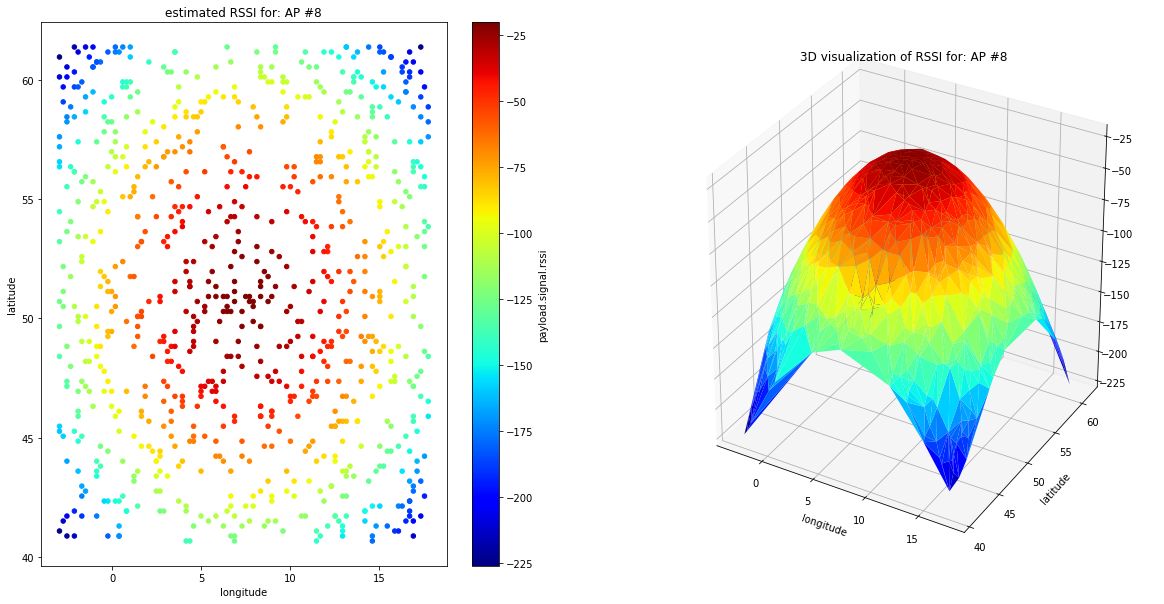

In [554]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



signal_quality_for_ap_per_location_df = wifi_signal_quality_df.sort_values("time").groupby(["payload.ssid"])

for index, (name, group) in enumerate(signal_quality_for_ap_per_location_df):
    
    fig = plt.figure(figsize=(20,10))
    
    ax = fig.add_subplot(121)
    plt.title(f"estimated RSSI for: {name}")
    group.plot(kind='scatter', x="longitude", y='latitude',  c="payload.signal.rssi", cmap=plt.get_cmap("jet"), ax=ax);

    
    
    ax = fig.add_subplot(122,projection="3d")
    plt.title(f"3D visualization of RSSI for: {name}")
    plt.xlabel("longitude")
    plt.ylabel("latitude")    

    
    x = group['longitude'].values
    y = group['latitude'].values
    z = group['payload.signal.rssi'].values
    
    
    ax.plot_trisurf(x,y,z, antialiased=True ,cmap=plt.get_cmap("jet"))

Total signal quality esttimation

- https://stackoverflow.com/questions/53952294/how-to-plot-surface-without-using-meshgrid

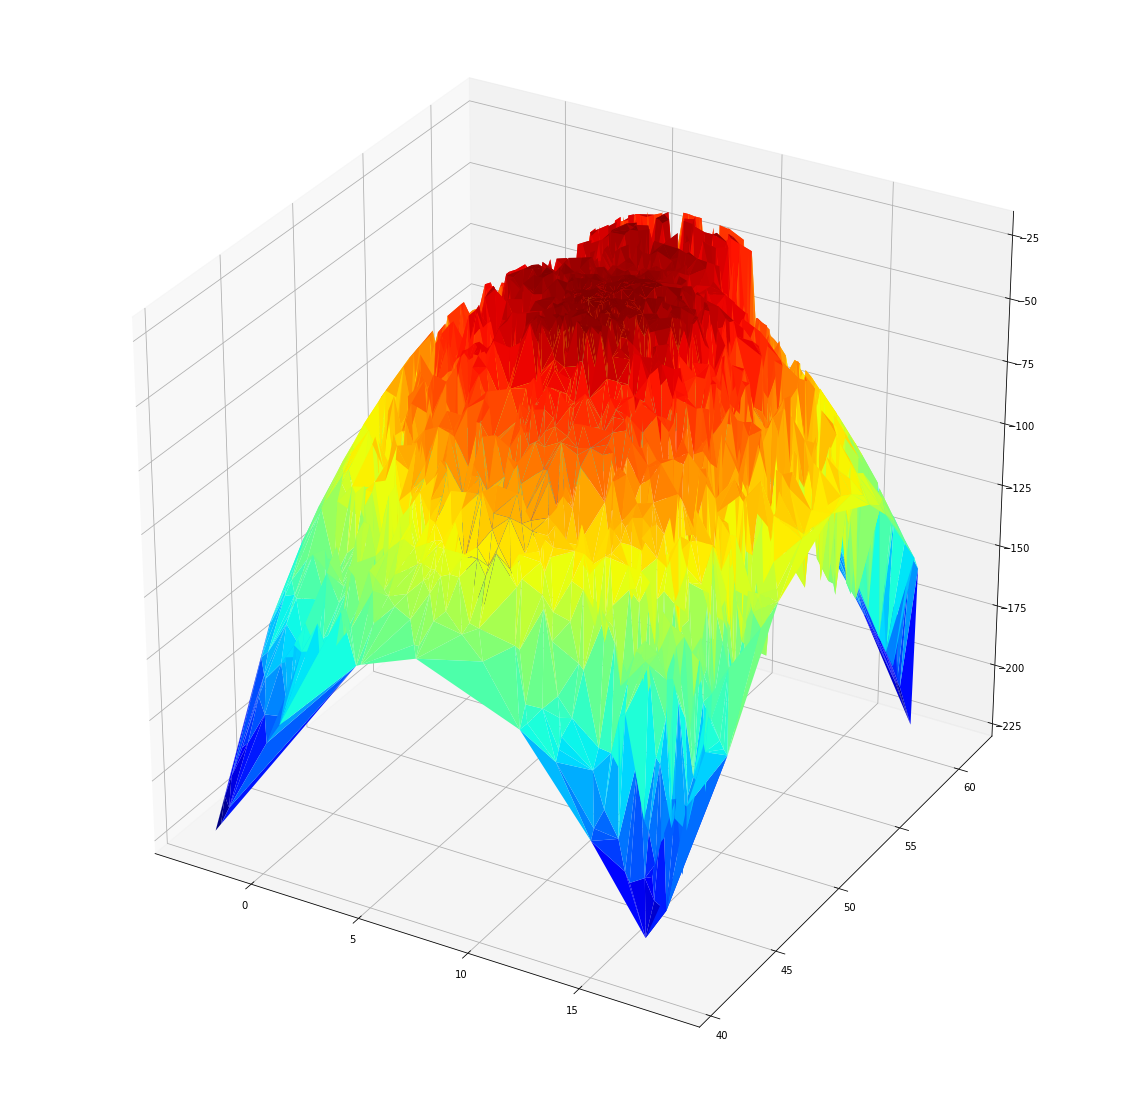

In [562]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# data = # your matrix here

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")

x = wifi_signal_quality_df['longitude'].values
y = wifi_signal_quality_df['latitude'].values
z = wifi_signal_quality_df['payload.signal.rssi'].values

ax.plot_trisurf(x,y,z, antialiased=True ,cmap=plt.get_cmap("jet"));

## GPS Positions in the World

In [563]:
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon

In [477]:
geometry = [Point(xy) for xy in zip(wifi_signal_quality_df["longitude"], wifi_signal_quality_df['latitude'])]

In [564]:
geo_df = gpd.GeoDataFrame(wifi_signal_quality_df,
      geometry = geometry);

geo_df.head()

time  longitude   latitude  \
0 2019-11-17 14:55:48  -2.970135  56.571071   
1 2019-11-17 14:55:49  15.025965  58.872898   
2 2019-11-17 14:55:50   9.794541  59.919183   
3 2019-11-17 14:55:51  14.188937  49.037820   
4 2019-11-17 14:55:51  14.607451  58.454384   

                              device.id  payload.signal.rssi payload.ssid  \
0  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0                 -158        AP #8   
1  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0                 -139        AP #8   
2  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0                 -104        AP #8   
3  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0                  -70        AP #8   
4  8efbe4bf-28d0-41a2-a95f-2a6b8e68faa0                 -127        AP #8   

                    geometry  
0  POINT (-2.97013 56.57107)  
1  POINT (15.02597 58.87290)  
2   POINT (9.79454 59.91918)  
3  POINT (14.18894 49.03782)  
4  POINT (14.60745 58.45438)

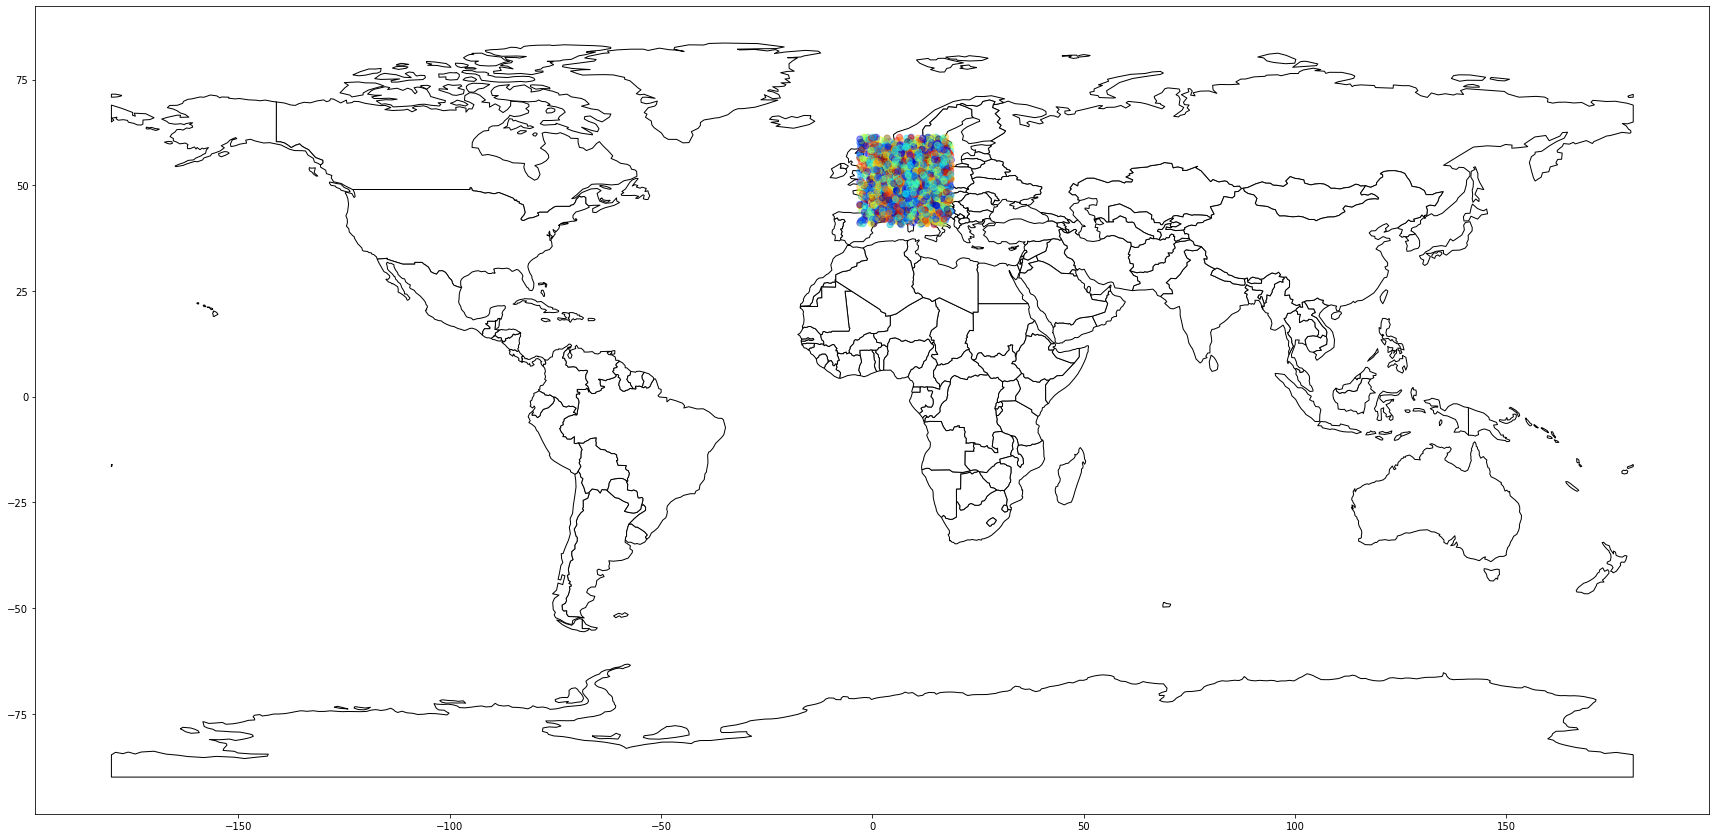

In [565]:
# https://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


base = world.plot(color='white', edgecolor='black', figsize=(30,30),)


geo_df.plot(label="rssi",
    c="payload.signal.rssi", cmap=plt.get_cmap("jet"),
    alpha=0.4, figsize=(30,30), ax=base);